In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import googletrans
from googletrans import Translator
from tqdm import tqdm
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
import pickle
import os
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

/Users/pavithra/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis

In [2]:
#Load dataset
products = pd.read_csv("products.tsv",sep='\t')
reviews = pd.read_csv("reviews.tsv",sep='\t')

#key words got from the blog
Premium = ['High-end','luxury','premium','trend-led','trend','elevate','cost','Vampire’s Wife','Candice Cuoco','lambskin','leather','Off-White','Virgil']
adapt_to_temp = ['cozy','neck warmer','snood','detachable-snood','detachable','balaclavas','Acne studios','Acne','Supreme','bandanas','Handkerchiefs','ME and em','JD williams','jd']
Comfort = ['front','front & center','center','comfort','breathable','lightweight','ease','feel at ease','SilkFred','Tilly','maskne','range of sizes','different sizes','adjustable metal nose piece','adjustable','silk','matching','Gemma Collins','Dolce & Gabbana','Dolce','SLIP','In The Style']
Sportmask = ['Under Armour','UA','adjustable','different sizes','Spacer','air pockets','breathable','open-cell foam','Iso-Chill technology','disperses heat','subtle','Forever 21','Nike','gym','safe','snood','VaporKnit']
Formal = ['Decorative','Revolve','mask covering','jersey mask','Grlfrnd','katie may','matching','bhldn','bridal']
Value = ['multi-packs','multiple','value','variation','Bumper','shein','accessories']
Accessories = ['mask chains','mask chain','Pockets','pouches','Sanitizer','glove','spare mask']
Others = ['free','novelty','vacation','festive','interchangeable','reflective materials']

In [3]:
products.product_url.unique()

array(['https://au.iherb.com/pr/Hwipure-Disposable-KF94-N95-KN95-FFP2-Mask-1-Mask/103205',
       'https://au.iherb.com/pr/HIGUARD-Disposable-KF94-N95-KN95-FFP2-Mask-1-Mask/101774',
       'https://au.iherb.com/pr/SunJoy-KN95-Professional-Protective-Disposable-Face-Mask-10-Pack/101955',
       'https://au.iherb.com/pr/Lozperi-Copper-Mask-Adult-Black-1-Mask/103838',
       'https://au.iherb.com/pr/Zidian-Disposable-Protective-Mask-50-Pack/102734',
       'https://au.iherb.com/pr/La-Hauteur-Disposable-KF94-N95-KN95-FFP2-Mask-1-Mask/100837',
       'https://au.iherb.com/pr/YJ-Corporation-Disposable-KF94-Mask-for-Kids-1-Mask/100840',
       'https://au.iherb.com/pr/Hwipure-Disposable-KF94-N95-KN95-FFP2-Mask-25-Masks/103204',
       'https://au.iherb.com/pr/Lozperi-Copper-Mask-Adult-Gray-1-Mask/103840',
       'https://au.iherb.com/pr/Puritas-10-Days-Mask-Large-3-Pack/103743',
       'https://au.iherb.com/pr/Dr-Puri-Disposable-KF94-N95-KN95-FFP2-Mask-20-Masks/102522',
       'https://au.ihe

In [4]:
products.product_id.nunique()

27

In [5]:
products.describe()

,product_id,product_price
count,27.000000,27.000000
mean,102093.888889,16.969259
std,1499.395964,15.505124
min,99829.000000,2.950000
25%,100838.000000,6.260000
50%,101955.000000,8.860000
75%,103790.500000,22.440000
max,104023.000000,50.190000


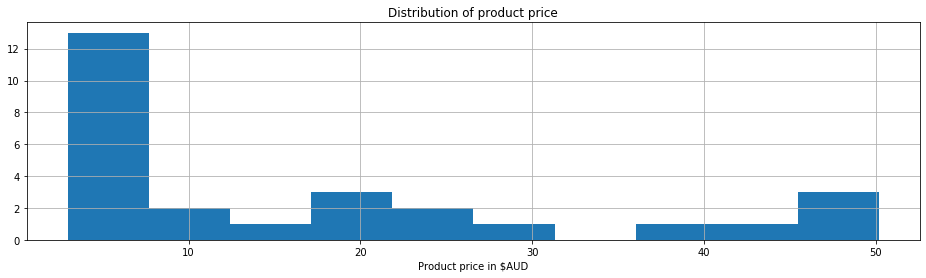

In [6]:
#Understanding the distribution of product prices
products[products.product_price<51].product_price.hist(bins=10, figsize=(16,4))
plt.xlabel('Product price in $AUD')
plt.title('Distribution of product price')
plt.show()

In [7]:
data = products.merge(reviews,left_on='product_id',right_on='productId',how='right')
data = data[~data.duplicated(keep='last')]
data.describe()

,product_id,product_price,abuseCount,helpfulNo,helpfulYes,imagesCount,productId,profileInfo.ugcSummary.answerCount,profileInfo.ugcSummary.reviewCount,ratingValue,score
count,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3759.000000,3759.000000,3765.000000,3.765000e+03
mean,101218.972643,16.044173,0.044887,0.053652,0.585126,0.081806,101218.972643,3.629689,80.334131,44.448871,1.607118e+09
std,1144.483835,9.674920,0.244718,0.350786,4.014651,0.431493,1144.483835,27.350866,265.030416,9.914370,5.329796e+06
min,99829.000000,2.950000,0.000000,0.000000,0.000000,0.000000,99829.000000,0.000000,0.000000,10.000000,1.589172e+09
25%,100237.000000,8.860000,0.000000,0.000000,0.000000,0.000000,100237.000000,0.000000,7.000000,40.000000,1.604809e+09
50%,101029.000000,17.720000,0.000000,0.000000,0.000000,0.000000,101029.000000,0.000000,29.000000,50.000000,1.608204e+09
75%,101955.000000,22.440000,0.000000,0.000000,0.000000,0.000000,101955.000000,1.000000,81.000000,50.000000,1.611330e+09
max,104023.000000,50.190000,4.000000,9.000000,139.000000,5.000000,104023.000000,673.000000,8087.000000,50.000000,1.642404e+09


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3765 entries, 0 to 3848
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_id                          3765 non-null   int64  
 1   product_name                        3765 non-null   object 
 2   product_price                       3765 non-null   float64
 3   price_currency                      3765 non-null   object 
 4   product_availability                3765 non-null   object 
 5   product_url                         3765 non-null   object 
 6   source_url                          3765 non-null   object 
 7   abuseCount                          3765 non-null   int64  
 8   customerNickname                    3765 non-null   object 
 9   helpfulNo                           3765 non-null   int64  
 10  helpfulYes                          3765 non-null   int64  
 11  id                                  3765 no

In [9]:
((data.isna().sum()/data.shape[0])*100).round(2)

product_id                             0.00
product_name                           0.00
product_price                          0.00
price_currency                         0.00
product_availability                   0.00
product_url                            0.00
source_url                             0.00
abuseCount                             0.00
customerNickname                       0.00
helpfulNo                              0.00
helpfulYes                             0.00
id                                     0.00
imagesCount                            0.00
languageCode                           0.00
postedDate                             0.00
productId                              0.00
profileInfo.ugcSummary.answerCount     0.16
profileInfo.ugcSummary.reviewCount     0.16
ratingValue                            0.00
reviewText                             0.00
reviewTitle                            0.00
reviewed                               0.00
score                           

There are __48%__ null values in __*translation.reviewText*__ and __*translation.reviewTitle*__ column and __0.16%__ null values in __*profileInfo.ugcSummary.answerCount*__ and __*profileInfo.ugcSummary.reviewCount*__ column.

In [10]:
data.postedDate.max()

'2021-02-07T00:56:39.055Z'

In [11]:
data.postedDate.min()

'2020-05-12T13:35:10.337Z'

In [12]:
#impute values for null values
data['translation.reviewText'] = np.where(data['translation.reviewText'].isnull(),'Not available',data['translation.reviewText'])
data['translation.reviewTitle'] = np.where(data['translation.reviewTitle'].isnull(),'Not available',data['translation.reviewTitle'])
data['profileInfo.ugcSummary.answerCount'] = np.where(data['profileInfo.ugcSummary.answerCount'].isnull(),0.0,data['profileInfo.ugcSummary.answerCount'])
data['profileInfo.ugcSummary.reviewCount'] = np.where(data['profileInfo.ugcSummary.reviewCount'].isnull(),0.0,data['profileInfo.ugcSummary.reviewCount'])


#get non-english reviews from translated column
data['reviewText_final'] = np.where(data['languageCode'] != 'en-US',data['translation.reviewText'],data['reviewText'])

#Get market info from language code
data['Reviewer_Geo'] = data['languageCode'].str.split('-',2).str[1]


#modify rating scale

data['rating_value']= np.where(data['ratingValue'] == 10,1.0,
         np.where(data['ratingValue'] == 20,2.0,
                  np.where(data['ratingValue'] == 30,3.0,
                           np.where(data['ratingValue'] == 40,4.0,
                                    np.where(data['ratingValue'] == 50,5.0,0.0)))))

In [13]:
df_rating = data.groupby(['rating_value']).size().reset_index().rename(columns = {0 : 'rating count'})
df_rating

,rating_value,rating count
0,1.0,125
1,2.0,118
2,3.0,281
3,4.0,674
4,5.0,2567


I assume the above rating values to be between 1 to 5. Hence I transform 10 to 1, 20 to 2. and respectively

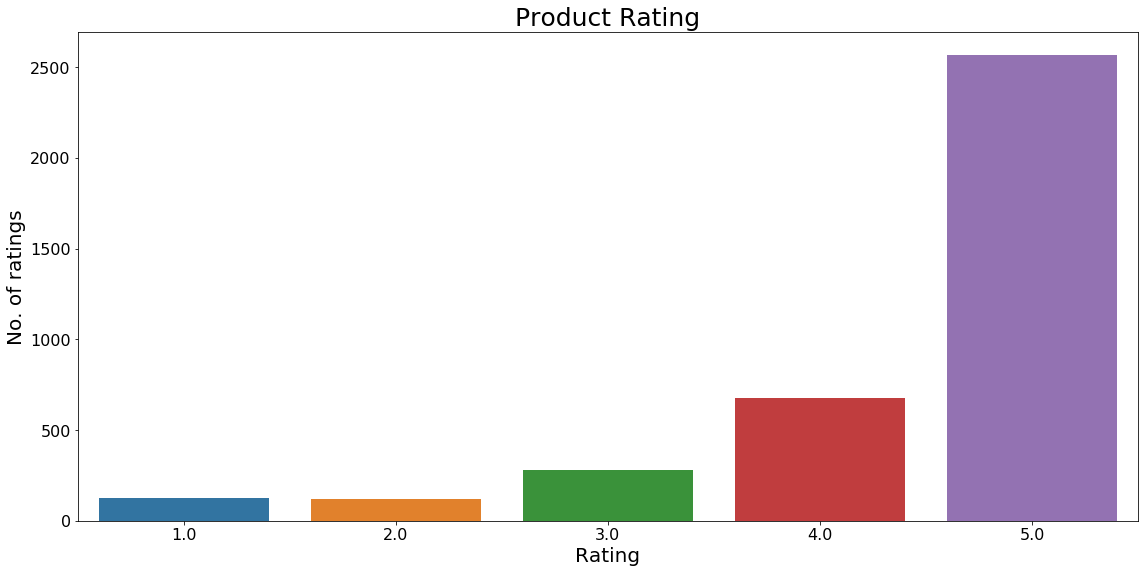

In [14]:
plt.figure(figsize = (19,9))
sns.barplot(df_rating['rating_value'], df_rating['rating count'] )
plt.xlabel('Rating', fontsize = 20)
plt.ylabel('No. of ratings', fontsize = 20)
plt.xticks(rotation = 0, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Product Rating', fontsize = 25)
plt.show()

In [15]:
ab_cnt_value = data.groupby(['abuseCount']).size().reset_index().rename(columns = {0 : 'abuseCount Value'})
ab_cnt_value.head(10)

,abuseCount,abuseCount Value
0,0,3621
1,1,125
2,2,14
3,3,4
4,4,1


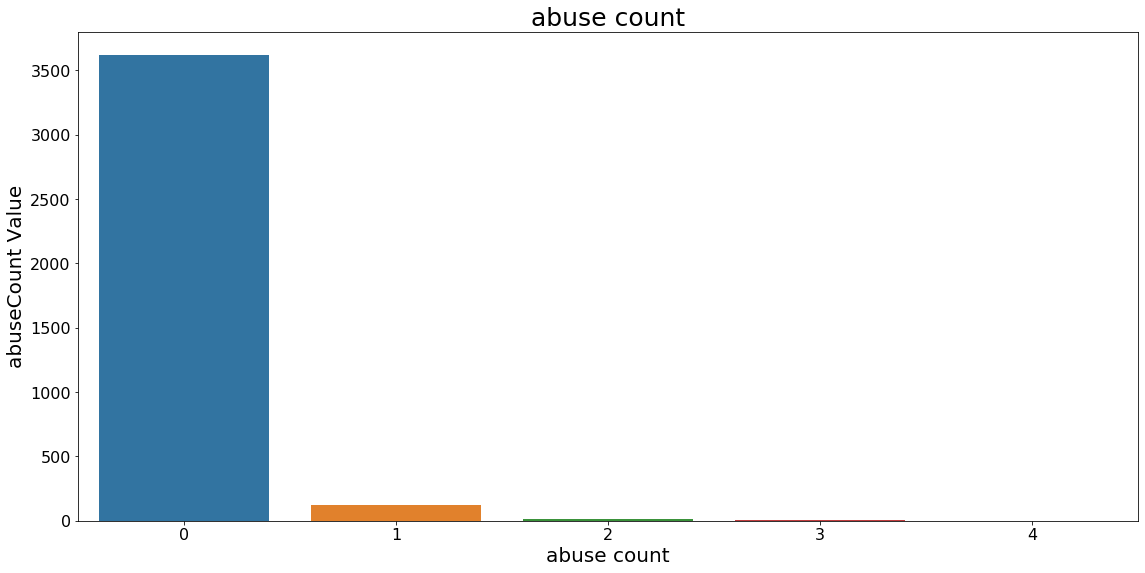

In [16]:
plt.figure(figsize = (19,9))
sns.barplot(ab_cnt_value['abuseCount'], ab_cnt_value['abuseCount Value'] )
plt.xlabel('abuse count', fontsize = 20)
plt.ylabel('abuseCount Value', fontsize = 20)
plt.xticks(rotation = 0, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('abuse count', fontsize = 25)
plt.show()

In [17]:
data.helpfulNo.unique()

array([0, 1, 2, 3, 4, 5, 9, 6])

In [18]:
data.helpfulYes.unique()

array([  6,   0,   1,   5,   4,   3,  21,  20,  16,   2,  14,  12,  31,
        22,   8,  10,   7, 139,  41,  68,  24,  55,  35,  11,  50,   9,
        25,  13,  15,  17,  95,  78,  33])

In [19]:
data.product_availability.unique()

array(['http://schema.org/InStock'], dtype=object)

In [20]:
data.imagesCount.unique()

array([1, 0, 2, 4, 3, 5])

# Translate non-english review titles

In [21]:
%%time
#translate for reviewTitle
translations = {}
translator = Translator()
unique_elements = list(data[data['languageCode'] != 'en-US']['reviewTitle'].unique())
for element in unique_elements:
    # add translation to the dictionary
    translations[element] = translator.translate(element).text
    #time.sleep(1)
    
data["reviewTitle"].replace(translations, inplace=True)
data.to_csv('translated_data.tsv',sep='\t',index=False)

CPU times: user 4.95 s, sys: 426 ms, total: 5.38 s
Wall time: 7min 18s


In [22]:
data = pd.read_csv('translated_data.tsv',sep='\t')

# Preprocess and extract addtional features

In [23]:
data[["product_brand_name","product_name_temp"]] = data['product_name'].str.split(',',1,expand = True)
data['Mask type'] = np.where(data['product_name'].str.contains('disposable',case = False),'Disposable',
                                    np.where(data['product_name'].str.contains('reuseable',case = False),'Reuseable',
                                             np.where(data['product_name'].str.contains('replaceable',case = False),'Replaceable','Others')))
          
data['Fabric type'] = np.where(data['product_name'].str.contains('copper',case = False),'Copper',
                                    np.where(data['product_name'].str.contains('cotton',case = False),'Cotton','Others'))
              
data['Usage type'] = np.where(data['product_name'].str.contains('fashion',case = False),'Fashion',
                                    np.where(data['product_name'].str.contains('professional',case = False),'Professional','Others'))
              
data['Bundle size'] = data['product_name_temp'].str.rsplit(' ', 2,expand = True)[1]

data['Mask Age group'] = np.where(data['product_name'].str.contains('adult',case = False),'Adult',
                                    np.where(data['product_name'].str.contains('kids',case = False),'Kids',
                                            np.where(data['product_name'].str.contains('neutral',case = False),'Neutral','Not specified')))
 
data['Mask size group'] = np.where(data['product_name'].str.contains('large',case = False),'large',
                                    np.where(data['product_name'].str.contains('medium',case = False),'medium',
                                            np.where(data['product_name'].str.contains('small',case = False),'small',
                                                    np.where(data['product_name'].str.contains('s-m',case = False),'S-M','Not specified'))))
 
      
grey_lst = ['grey','gray']                                    
data['color'] = np.where(data['product_name'].str.contains('black',case = False),'Black',
                                    np.where(data['product_name'].str.contains(''.join(grey_lst),case=False),'Grey',
                                            np.where(data['product_name'].str.contains('blush',case = False),'Blush','Not specified')))

cert_lst = ['kn95','n95','ffp2','kf94']
data['certified'] = np.where(data['product_name'].str.contains('|'.join(cert_lst),regex=True,case=False),'Certified','Not specified')

data['Bundle size'] = data['Bundle size'].astype(float)
data['Cost per mask'] = data['product_price']/data['Bundle size']
#bucketize product price
#done based on data distribution
data['price_bucket'] = np.where(data['Cost per mask']<=1,'low range',
                                       np.where((data['Cost per mask']>1) & (data['Cost per mask']<=5),'medium range',
                                               np.where(data['Cost per mask']>5,'high-end','others')))


del  data['product_name_temp']

# Preprocessing for Text data

In [24]:
#text preprocessing starts here

#Tokenize each word in a sentence
def identify_tokens(row):
    review = row['reviewText_final']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

data['words'] = data.apply(identify_tokens, axis=1)

#Remove stopwords
stopswords = list(stopwords.words("english"))   
sw_list = ['like','good','great','mask','qualiti','masks']
stopswords.extend(sw_list)

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stopswords]
    return (meaningful_words)

data['meaningful_words'] = data.apply(remove_stops, axis=1)
data['meaningful_words'] = data['meaningful_words'].dropna()

#Perform stemming
stemming = PorterStemmer()
def stem_list(row):
    my_list = row['meaningful_words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

data['stemmed_words'] = data.apply(stem_list, axis=1)

#Rejoin the words
def rejoin_words(row):
    my_list = row['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

data['processed'] = data.apply(rejoin_words, axis=1)

#convert each word into vectors
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(data['processed'])

data = data[['product_id', 'product_name', 'product_price', 'price_currency',
       'product_availability', 'product_url', 'source_url',
       'product_brand_name', 'Mask type', 'Fabric type', 'Usage type',
       'Bundle size', 'Mask Age group', 'Mask size group', 'color',
       'certified', 'abuseCount', 'customerNickname', 'helpfulNo',
       'helpfulYes', 'id', 'imagesCount', 'languageCode', 'postedDate',
       'productId', 'profileInfo.ugcSummary.answerCount',
       'profileInfo.ugcSummary.reviewCount', 'ratingValue', 'reviewText',
       'reviewTitle', 'reviewed', 'score',
       'translation.reviewText', 'translation.reviewTitle', 'reviewText_final',
       'Reviewer_Geo','Cost per mask', 'price_bucket', 'rating_value','Reviewer_Geo','processed']]



In [25]:
data.to_csv('processed_data.tsv',sep='\t',index=False)

In [26]:
data = pd.read_csv('processed_data.tsv',sep='\t')

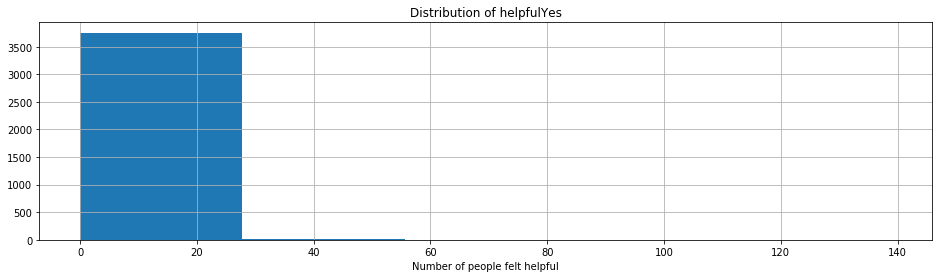

In [27]:
#Understanding the distribution of helpfulYes 
data[data.helpfulYes<=data.helpfulYes.max()].helpfulYes.hist(bins=5, figsize=(16,4))
plt.xlabel('Number of people felt helpful')
plt.title('Distribution of helpfulYes')
plt.show()

Less 2 users feel the reviews are helpful

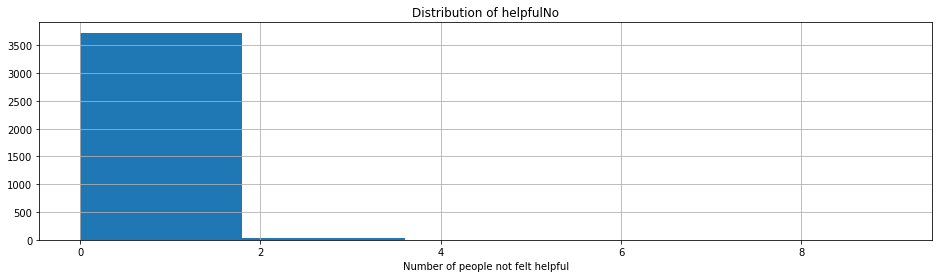

In [28]:
#Understanding the distribution of helpfulNo 
data[data.helpfulYes<=data.helpfulYes.max()].helpfulNo.hist(bins=5, figsize=(16,4))
plt.xlabel('Number of people not felt helpful')
plt.title('Distribution of helpfulNo')
plt.show()

Less 2 users feel the reviews are not helpful

In [29]:
data[data['helpfulNo'] == data['helpfulYes']][['helpfulYes','helpfulNo']].sort_values('helpfulYes')

,helpfulYes,helpfulNo
1,0,0
2511,0,0
2512,0,0
2514,0,0
2517,0,0
...,...,...
299,1,1
1009,1,1
1278,1,1
1287,2,2


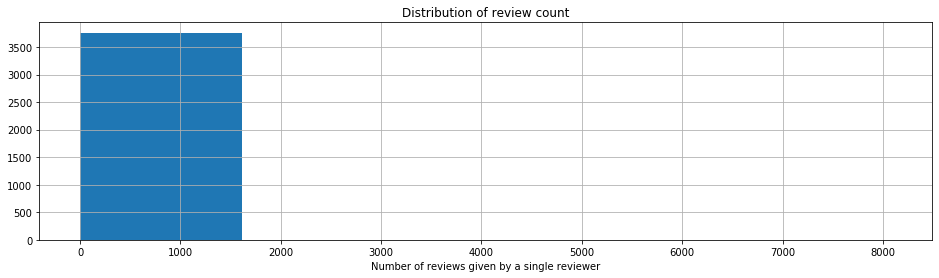

In [30]:
#Understanding the distribution of profileInfo.ugcSummary.reviewCount 
data[data.helpfulYes<=data['profileInfo.ugcSummary.reviewCount'].max()]['profileInfo.ugcSummary.reviewCount'].hist(bins=5, figsize=(16,4))
plt.xlabel('Number of reviews given by a single reviewer')
plt.title('Distribution of review count')
plt.show()

Most of the reviewers give less the 1600 reviews

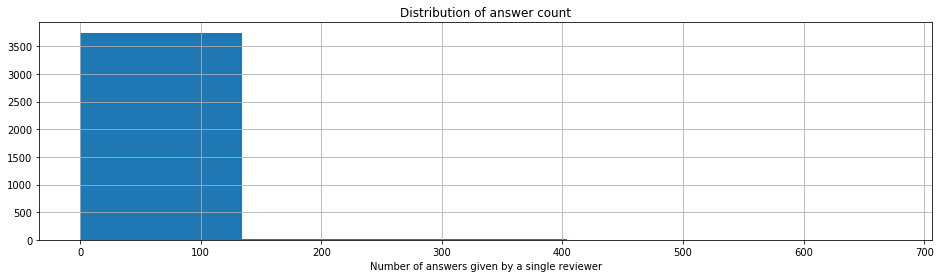

In [31]:
#Understanding the distribution of profileInfo.ugcSummary.answerCount 
data[data.helpfulYes<=data['profileInfo.ugcSummary.answerCount'].max()]['profileInfo.ugcSummary.answerCount'].hist(bins=5, figsize=(16,4))
plt.xlabel('Number of answers given by a single reviewer')
plt.title('Distribution of answer count')
plt.show()

In [32]:
data.processed = data.processed.fillna('')
data = data.replace({',': '_'}, regex=True)

Most of the reviewers answer less the 150 reviews

# Perform sentiment analysis

In [33]:
#Perform sentiment analysis to find out popular products (both in positive and negative way)
analyzer = SentimentIntensityAnalyzer()
def perform_sentiment_analysis(data):
    data['mixed_sentiment'] = [analyzer.polarity_scores(x)['compound'] for x in data['reviewText_final']]
    data['negative_sentiment'] = [analyzer.polarity_scores(x)['neg'] for x in data['reviewText_final']]
    data['neutral_sentiment'] = [analyzer.polarity_scores(x)['neu'] for x in data['reviewText_final']]
    data['positive_sentiment'] = [analyzer.polarity_scores(x)['pos'] for x in data['reviewText_final']]
    
    return data

In [34]:
data['price_bucket'].unique()

array(['high-end', 'medium range', 'low range'], dtype=object)

In [35]:
low_range = data[data['price_bucket'] == 'low range']
affordable = data[data['price_bucket'] == 'affordable']
medium_range = data[data['price_bucket'] == 'medium range']
high_end = data[data['price_bucket'] == 'high-end']
low_range_result = perform_sentiment_analysis(low_range)
affordable_result = perform_sentiment_analysis(affordable)
medium_range_result = perform_sentiment_analysis(medium_range)
high_end_result = perform_sentiment_analysis(high_end)

In [36]:
#Top 3 products with positive review - low range
low_range_result.sort_values('positive_sentiment').drop_duplicates('product_name',keep='last').tail(5)

,product_id,product_name,product_price,price_currency,product_availability,product_url,source_url,product_brand_name,Mask type,Fabric type,...,Reviewer_Geo,Cost per mask,price_bucket,rating_value,Reviewer_Geo.1,processed,mixed_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment
3723,104023,Kosette_ PM 2.5 Replaceable Filter_ 24 Filters,5.91,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Kosette-PM-2-5-Replace...,https://au.iherb.com/c/protective-face-masks,Kosette,Replaceable,Others,...,US,0.24625,low range,4.0,US,i realli way know work code regard filter they...,0.4786,0.037,0.88,0.083
1017,101029,Landsberg_ 3 Ply Disposable Protective Face Ma...,36.54,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Landsberg-3-Ply-Dispos...,https://au.iherb.com/c/protective-face-masks,Landsberg,Disposable,Others,...,CN,0.73080,low range,5.0,CN,well,0.2732,0.000,0.00,1.000
1807,102734,Zidian_ Disposable Protective Mask_ 50 Pack,15.35,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Zidian-Disposable-Prot...,https://au.iherb.com/c/protective-face-masks,Zidian,Disposable,Others,...,SA,0.30700,low range,5.0,SA,excel,0.5719,0.000,0.00,1.000
3244,101955,SunJoy_ KN95_ Professional Protective Disposab...,8.86,AUD,http://schema.org/InStock,https://au.iherb.com/pr/SunJoy-KN95-Profession...,https://au.iherb.com/c/protective-face-masks,SunJoy,Disposable,Others,...,DE,0.88600,low range,4.0,DE,well,0.2732,0.000,0.00,1.000
3764,100099,Luseta Beauty_ Disposable Protection Face Mask...,49.61,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Luseta-Beauty-Disposab...,https://au.iherb.com/c/protective-face-masks,Luseta Beauty,Disposable,Others,...,US,0.99220,low range,5.0,US,great,0.6249,0.000,0.00,1.000


In [37]:
low_range_result.sort_values(['positive_sentiment','helpfulYes']).drop_duplicates('product_name',keep='last').tail(3)

,product_id,product_name,product_price,price_currency,product_availability,product_url,source_url,product_brand_name,Mask type,Fabric type,...,Reviewer_Geo,Cost per mask,price_bucket,rating_value,Reviewer_Geo.1,processed,mixed_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment
2061,102734,Zidian_ Disposable Protective Mask_ 50 Pack,15.35,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Zidian-Disposable-Prot...,https://au.iherb.com/c/protective-face-masks,Zidian,Disposable,Others,...,US,0.3070,low range,4.0,US,good,0.4404,0.0,0.0,1.0
3453,101955,SunJoy_ KN95_ Professional Protective Disposab...,8.86,AUD,http://schema.org/InStock,https://au.iherb.com/pr/SunJoy-KN95-Profession...,https://au.iherb.com/c/protective-face-masks,SunJoy,Disposable,Others,...,US,0.8860,low range,3.0,US,ok,0.2960,0.0,0.0,1.0
3764,100099,Luseta Beauty_ Disposable Protection Face Mask...,49.61,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Luseta-Beauty-Disposab...,https://au.iherb.com/c/protective-face-masks,Luseta Beauty,Disposable,Others,...,US,0.9922,low range,5.0,US,great,0.6249,0.0,0.0,1.0


In [38]:
low_range_result.sort_values('negative_sentiment').drop_duplicates('product_name',keep='last').tail(3)

,product_id,product_name,product_price,price_currency,product_availability,product_url,source_url,product_brand_name,Mask type,Fabric type,...,Reviewer_Geo,Cost per mask,price_bucket,rating_value,Reviewer_Geo.1,processed,mixed_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment
3762,100099,Luseta Beauty_ Disposable Protection Face Mask...,49.61,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Luseta-Beauty-Disposab...,https://au.iherb.com/c/protective-face-masks,Luseta Beauty,Disposable,Others,...,JP,0.9922,low range,1.0,JP,not particularli recommend,-0.2044,0.475,0.525,0.0
3433,101955,SunJoy_ KN95_ Professional Protective Disposab...,8.86,AUD,http://schema.org/InStock,https://au.iherb.com/pr/SunJoy-KN95-Profession...,https://au.iherb.com/c/protective-face-masks,SunJoy,Disposable,Others,...,US,0.8860,low range,1.0,US,purchas regret fit well,-0.6623,0.763,0.237,0.0
1940,102734,Zidian_ Disposable Protective Mask_ 50 Pack,15.35,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Zidian-Disposable-Prot...,https://au.iherb.com/c/protective-face-masks,Zidian,Disposable,Others,...,FR,0.3070,low range,1.0,FR,bad qualiti,-0.5423,0.778,0.222,0.0


In [39]:
low_range_result.sort_values(['negative_sentiment','helpfulYes']).drop_duplicates('product_name',keep='last').tail(3)

,product_id,product_name,product_price,price_currency,product_availability,product_url,source_url,product_brand_name,Mask type,Fabric type,...,Reviewer_Geo,Cost per mask,price_bucket,rating_value,Reviewer_Geo.1,processed,mixed_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment
3762,100099,Luseta Beauty_ Disposable Protection Face Mask...,49.61,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Luseta-Beauty-Disposab...,https://au.iherb.com/c/protective-face-masks,Luseta Beauty,Disposable,Others,...,JP,0.9922,low range,1.0,JP,not particularli recommend,-0.2044,0.475,0.525,0.0
3433,101955,SunJoy_ KN95_ Professional Protective Disposab...,8.86,AUD,http://schema.org/InStock,https://au.iherb.com/pr/SunJoy-KN95-Profession...,https://au.iherb.com/c/protective-face-masks,SunJoy,Disposable,Others,...,US,0.8860,low range,1.0,US,purchas regret fit well,-0.6623,0.763,0.237,0.0
1940,102734,Zidian_ Disposable Protective Mask_ 50 Pack,15.35,AUD,http://schema.org/InStock,https://au.iherb.com/pr/Zidian-Disposable-Prot...,https://au.iherb.com/c/protective-face-masks,Zidian,Disposable,Others,...,FR,0.3070,low range,1.0,FR,bad qualiti,-0.5423,0.778,0.222,0.0


In [40]:
df_agg = low_range_result.groupby(['Reviewer_Geo','product_name']).agg({'positive_sentiment':'mean'})
g = df_agg['positive_sentiment'].groupby('Reviewer_Geo', group_keys=False)
top_products = g.apply(lambda x: x.sort_values(ascending=False).head(3)).reset_index()

In [41]:
top_products

,Reviewer_Geo,product_name,positive_sentiment
0,CN,Landsberg_ 3 Ply Disposable Protective Face Ma...,1.000000
1,CN,SunJoy_ KN95_ Professional Protective Disposab...,0.331667
2,DE,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.609000
3,DE,SunJoy_ KN95_ Professional Protective Disposab...,0.408000
4,FR,SunJoy_ KN95_ Professional Protective Disposab...,0.408792
5,FR,Zidian_ Disposable Protective Mask_ 50 Pack,0.368067
6,FR,Luseta Beauty_ Disposable Protection Face Mask...,0.089000
7,IL,Zidian_ Disposable Protective Mask_ 50 Pack,0.613000
8,IL,SunJoy_ KN95_ Professional Protective Disposab...,0.477000
9,IL,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.000000


In [42]:
df_agg = low_range_result.groupby(['Reviewer_Geo','product_name']).agg({'negative_sentiment':'mean'})
g = df_agg['negative_sentiment'].groupby('Reviewer_Geo', group_keys=False)
worst_products = g.apply(lambda x: x.sort_values(ascending=False).head(3)).reset_index()

In [43]:
worst_products

,Reviewer_Geo,product_name,negative_sentiment
0,CN,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.000000
1,CN,SunJoy_ KN95_ Professional Protective Disposab...,0.000000
2,DE,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.000000
3,DE,SunJoy_ KN95_ Professional Protective Disposab...,0.000000
4,FR,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.256000
5,FR,Zidian_ Disposable Protective Mask_ 50 Pack,0.069000
6,FR,SunJoy_ KN95_ Professional Protective Disposab...,0.046313
7,IL,Landsberg_ 3 Ply Disposable Protective Face Ma...,0.125000
8,IL,SunJoy_ KN95_ Professional Protective Disposab...,0.006700
9,IL,Zidian_ Disposable Protective Mask_ 50 Pack,0.000000


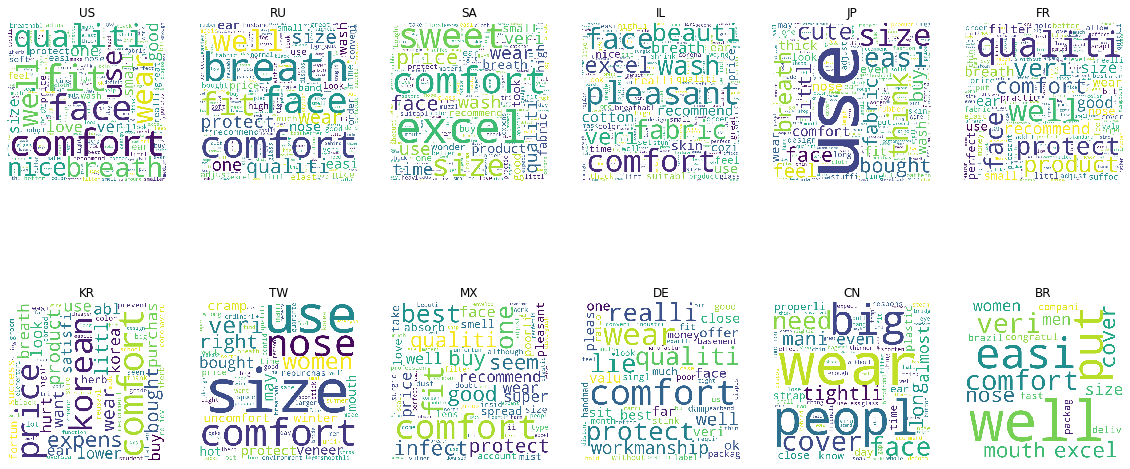

In [44]:
rest=data['Reviewer_Geo'].value_counts()[:12].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(6,6,i+1)
        corpus=data[data['Reviewer_Geo']==r]['processed'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=600, height=600).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
        
produce_wordcloud(rest)

In [45]:
high_end = high_end.replace({"\(": ''}, regex=True)
high_end = high_end.replace({"\)": ''}, regex=True)
high_end = high_end.replace({'/': ''}, regex=True)
low_range_result = low_range_result.replace({'\n': '<br>'}, regex=True)
affordable = affordable.replace({'\n': '<br>'}, regex=True)
medium_range = medium_range.replace({'\n': '<br>'}, regex=True)
high_end = high_end.replace({'\n': '<br>'}, regex=True)

# Save results

In [46]:
low_range_result.to_csv('output/low_range_result.csv', index=False)
affordable.to_csv('output/affordable_result.csv', index=False)
medium_range.to_csv('output/medium_range_result.csv', index=False)
high_end.to_csv('output/high_end_result.csv', index=False)